# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [56]:
# Импорт библиотек
import numpy as np  # для работы с массивами
import pandas as pd  # для работы с DataFrame 
import seaborn as sns  # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt  # для построения графиков
from sklearn.metrics import mean_absolute_percentage_error # для расчета метрики MAPE
from sklearn.linear_model import LinearRegression  # для построения модели линейной регрессии
from sklearn.model_selection import cross_validate  # для кросс-валидации

%matplotlib inline

Прочитаем исходные данные:

In [3]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
data.info()  # посмотрим на общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


В данных отсутствуют пропуски, а также все переменные числовые - целые ('Well') или с плавающей точкой. Это хорошо, так как не нужно проводить очисткку данных.

In [5]:
data.describe()  # посмотрим на статистики

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


На основе предоставленной статистики можно сделать следующие выводы:

#### 1. **Распределение признаков**:
   - **Por (Пористость)**: Среднее значение пористости составляет 14.99% с разбросом от 6.55% до 23.55%. Среднее значение близко к медиане (15.07%), что указывает на относительно нормальное распределение. Однако значения имеют широкий диапазон.
   - **Perm (Проницаемость)**: Среднее значение составляет 4.33, варьируется от 1.13 до 9.87, что указывает на достаточно широкий разброс проницаемости между скважинами. Также близко к медиане - 4.03.
   - **AI (Акустический импеданс)**: Среднее значение — 2.97, варьируется от 1.28 до 4.63, что указывает на относительно узкий диапазон, что может свидетельствовать о схожих условиях для большинства скважин.
   - **Brittle (Хрупкость)**: Среднее значение 48.16% и варьируется от 10.94% до 84.33%. Большой диапазон свидетельствует о значительных различиях в хрупкости среди скважин.
   - **TOC (Общий органический углерод)**: Среднее значение 0.99%, разброс от -0.19% до 2.18%. Наличие отрицательных значений может указывать на потенциальные ошибки или особенности метода измерения.
   - **VR (Коэффициент отражения витринита)**: Среднее значение 1.96, варьируется от 0.93 до 2.87. Показатель имеет относительно узкий диапазон, что свидетельствует о близких условиях для большинства скважин.

#### 2. **Целевой признак (Prod)**:
   - Средняя добыча газа составляет 4311.22 млн кубических футов в сутки. Добыча варьируется от 2107.14 до 6662.62, что указывает на достаточно широкий диапазон значений. Большое стандартное отклонение (992.04) свидетельствует о значительной изменчивости между различными скважинами.

/var/folders/8_/y936460960110gnpk46t3fw00000gn/T/ipykernel_86414/3448640906.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


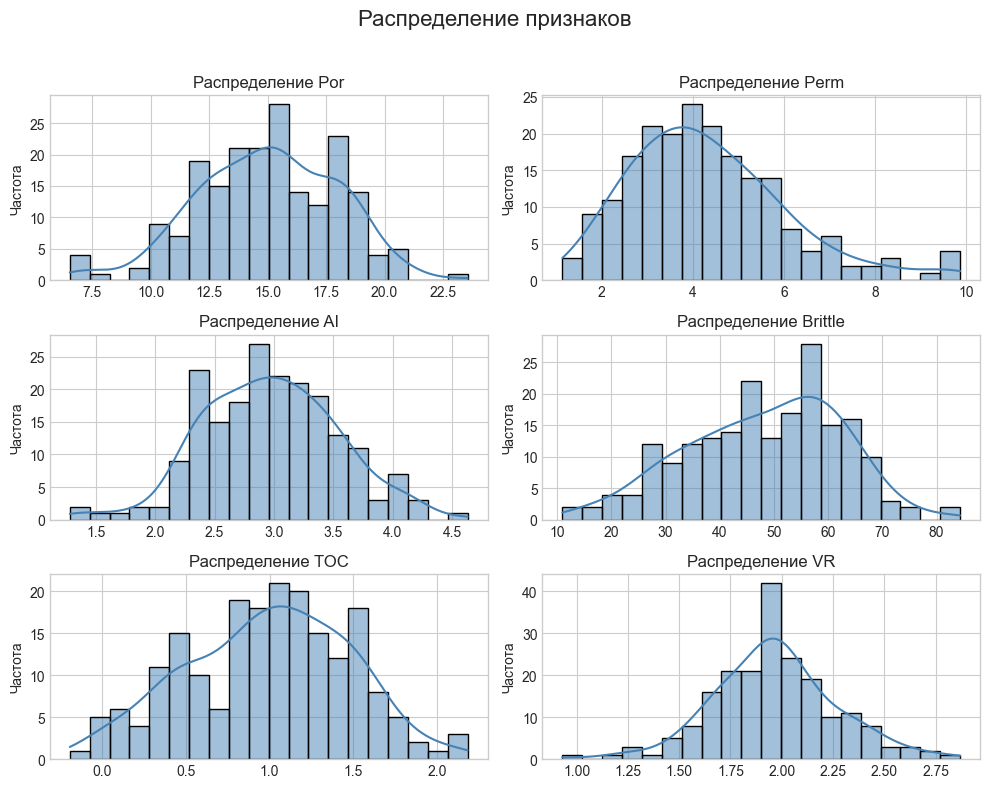

In [6]:
plt.style.use('seaborn-whitegrid')
sns.set_palette("muted")

# Построим графики гистограмм для каждого признака
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
fig.suptitle('Распределение признаков', fontsize=16)

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    sns.histplot(data[feature], kde=True, bins=20, ax=ax, color='steelblue')
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Частота')

plt.tight_layout(rect=[0, 0, 1, 0.96]);
plt.show();

Распределение признаков:

* Por (Пористость) и Perm (Проницаемость) имеют относительно нормальное распределение, но с небольшим смещением влево.
* AI (Акустический импеданс) также выглядит нормально распределенным с небольшим количеством выбросов.
* Brittle (Хрупкость) показывает однородное распределение, но с доминирующими значениями в диапазоне 30-60%.
* TOC (Органический углерод) показывает смещение влево и имеет небольшое количество отрицательных значений.
* VR (Коэффициент отражения витринита) имеет относительно узкий диапазон значений, сосредоточенный в пределах 1.7–2.1.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

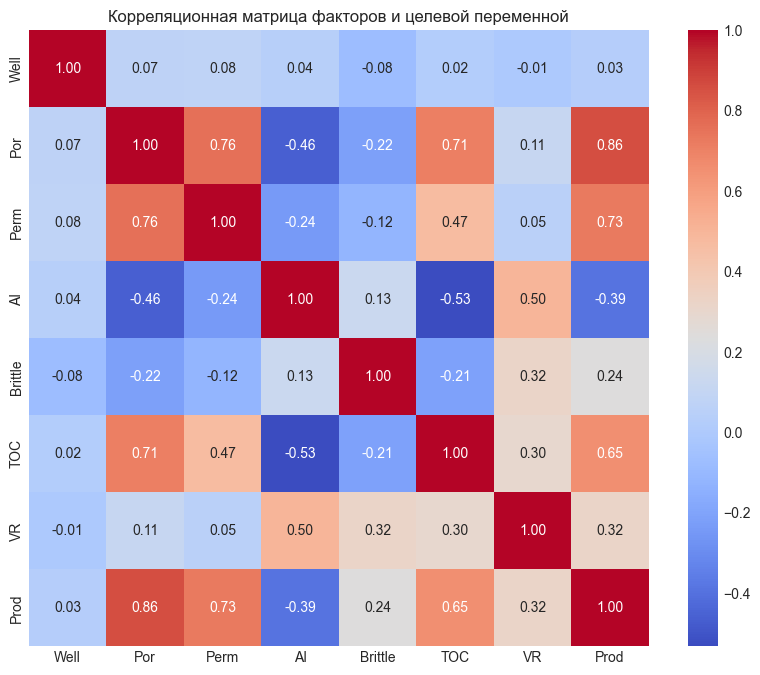

Ранг корреляционной матрицы = 8
Определитель корреляционной матрицы =  0.0007


In [7]:
# Построим корреляционную матрицу и визуализируем ее с помощью тепловой карты
correlation_matrix = data.corr()

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Корреляционная матрица факторов и целевой переменной')
plt.show();

# Вычисление ранга и определителя корреляционной матрицы
matrix_rank = np.linalg.matrix_rank(correlation_matrix)
matrix_determinant = np.linalg.det(correlation_matrix)

print('Ранг корреляционной матрицы =', matrix_rank)
print('Определитель корреляционной матрицы = ', round(matrix_determinant,4))

1) На основании построенной корреляционной матрицы можно сделать вывод, что сильнее всего коррелируют с целевой переменной следующие факторы: 'Por'/'Пористость' (0.86), 'Perm'/'Проницаемость' (0.73) - сильная прямая корреляционная связь. Среднюю связь с целевым признаком имеет признак 'TOC'/'Общий органический углерод' (0.65).

2) На основании полученных значений ранга корреляционной матрицы и определителя, можно сделать следующие выводы:

* Определитель практически равен нулю, что говорит о плохой обусловленности и вырожденности корреляционной матрицы.
* О чистой коллинеарности говорить не приходится, так как ранг максимальный и равен 8 (количеству признаков), а факторов, между которыми корреляция равнялась бы единице или была бы близка к ней, нет. Формально признаки линейно независимы. Однако мы имеем дело с мультиколлинеарностью. Во-первых, определитель близок к нулю. Во-вторых, факторы 'Por' - 'Perm' и 'Por' - 'TOC' очень сильно скоррелированы. Это может повлиять на стабильность оценки коэффициентов в модели линейной регрессии и вызвать проблемы с интерпретацией результатов.
* В данном случае модель классической линейной регрессии по методу наименьших квадратов теоретически применима (как в "ручном" варианте, так и в готовой модели линейной регрессии из модуля sklearn). Однако проблемы мультиколлинеарности могут привести к нестабильности коэффициентов и отсутствию их смысла и практической интерпретации. Для уменьшения этого эффекта можно использовать методы регуляризации (например, Ridge или Lasso), которые помогут снизить влияние мультиколлинеарных признаков. Или же удалить сильно скоррелированные признаки.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [8]:
X = data.drop(['Prod'], axis=1)  # матрица наблюдений
y = data['Prod'].values  # вектор ответов в виде одномерного массива
index = ['intercept'] + list(X.columns)  # названия факторов
n = X.shape[0]
X = np.column_stack((np.ones(n), X))  # вектор единиц + матрица наблюдений

coeff = np.linalg.inv(X.T @ X) @ X.T @ y  # модель линейной регрессии по матричной формуле МНК
coeff_series = pd.Series(coeff.round(), index=index)  # коэффициенты при факторах - параметры линейной регрессии
coeff_series

intercept   -1232.0
Well            0.0
Por           230.0
Perm          116.0
AI           -365.0
Brittle        25.0
TOC           -78.0
VR            785.0
dtype: float64

* Среди признаков есть неинформативные признаки, которые не оказывают влияния на целевую переменную или оказывают шумовое влияние - **Wel (идентификатор скважины)** и **Brittle (коэффициент хрупкости скважины)**.

* Проведем интерпретацию нескольких коэффициентов полученной модели линейной регрессии: 
1. **Por (Пористость)**: Коэффициент равен **230**
   - Это означает, что при увеличении пористости скважины на 1%, добыча газа увеличивается в среднем на 230 млн кубических футов в сутки, при прочих равных условиях. 
   - Высокое положительное значение коэффициента указывает на то, что пористость является важным фактором, способствующим увеличению добычи газа. Это объяснимо, так как более высокая пористость способствует большему скоплению газа в породе.
2. **AI (Акустический импеданс)**: Коэффициент равен **-365**
   - Отрицательное значение коэффициента указывает на обратную зависимость. Увеличение акустического импеданса на 1 единицу приводит к снижению добычи газа на 365 млн кубических футов в сутки, при прочих равных.
   - Это может свидетельствовать о том, что более плотные и менее пористые породы, имеющие высокий акустический импеданс, затрудняют добычу газа, уменьшая его объемы.
3. **VR (Коэффициент отражения витринита)**: Коэффициент равен **785**
   - Это самый высокий положительный коэффициент в модели, что говорит о значительном влиянии этого признака на добычу газа. Увеличение коэффициента отражения витринита на 1 единицу связано с увеличением добычи на 785 млн кубических футов в сутки.
   - Высокий коэффициент может свидетельствовать о том, что возраст и термальная зрелость органического материала, измеряемые с помощью VR, являются важным фактором при определении качества резервуара для добычи газа.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [9]:
x_new = np.array([1, 106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])  # вектор для прогноза
y_new = 4748.315024  # истинное значение производства газа
y_new_pred = x_new @ coeff  # прогноз производства газа на основании полученных коэффициентов линейной регрессии
abs_error = np.round(np.abs(y_new - y_new_pred))  # расчет абсолютной ошибки
print('Абсолютная ошибка построенного прогноза для предложенной скважины = ', abs_error, 'млн кубических футов в день')

y_pred = X @ coeff  # прогноз выработки газа для всех скважин
mape = mean_absolute_percentage_error(y, y_pred) * 100  # расчет метрики MAPE качества модели регрессии
print('Средняя абсолютная ошибка в процентах = ', mape)

Абсолютная ошибка построенного прогноза для предложенной скважины =  25.0 млн кубических футов в день
Средняя абсолютная ошибка в процентах =  3.6279468451339456


1. **Абсолютная ошибка для предложенной скважины**:
   - **Абсолютная ошибка** составила **25.0 млн кубических футов в день**.
   - Это значение указывает на отклонение прогноза от фактического значения для конкретной скважины. Абсолютная ошибка в данном случае достаточно мала, что свидетельствует о хорошей способности модели предсказывать выработку газа на отдельных скважинах.

2. **Средняя абсолютная ошибка в процентах (MAPE)**:
   - **MAPE = 3.63%**, что говорит о том, что в среднем модель ошибается на 3.63% относительно фактических значений добычи газа.
   - Такое значение MAPE считается низким и свидетельствует о высокой точности модели, особенно в контексте задач, связанных с прогнозированием добычи природных ресурсов, где такой уровень погрешности допустим и приемлем.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

intercept   -1232.0
Well            0.0
Por           230.0
Perm          116.0
AI           -365.0
Brittle        25.0
TOC           -78.0
VR            785.0
dtype: float64


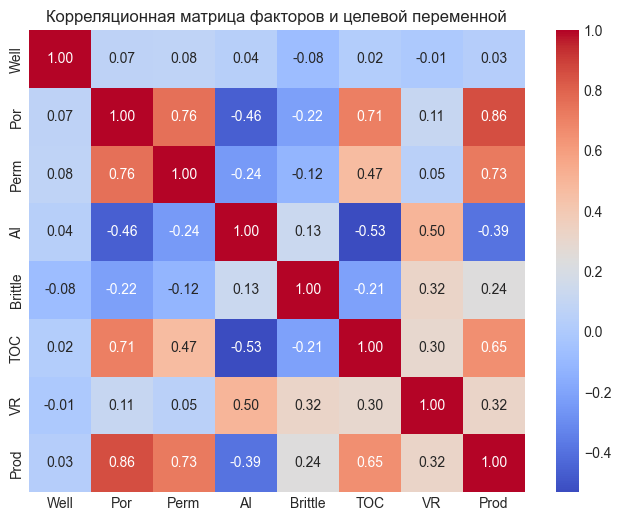

In [10]:
# Вывод коэффициентов линейной регрессии
print(coeff_series)

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Корреляционная матрица факторов и целевой переменной')
plt.show();

1) В модели есть фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции - **TOC (общий органический углерод)**. Корреляция говорит, что зависимость между данным фактором и целевой переменной пряма (+0.65), а модель говорит обратное (-78).
2)  Причины противоречий:
* **Мультиколлинеарность**: в данных наблюдается высокая корреляция между некоторыми факторами (например, Por и Perm). Мультиколлинеарность может вызвать искажение оценки коэффициентов, так как модель пытается распределить влияние признаков, которые оказывают схожий эффект на целевую переменную.
* **Сложные нелинейные зависимости**: корреляция оценивает только линейную связь, тогда как модель линейной регрессии может учитывать взаимодействия между признаками. Если признаки влияют друг на друга, это может изменить знак коэффициента.
3) **Шумовые признаки**: TOC может содержать скрытые факторы или быть шумовым, что не позволяет модели однозначно оценить его влияние.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

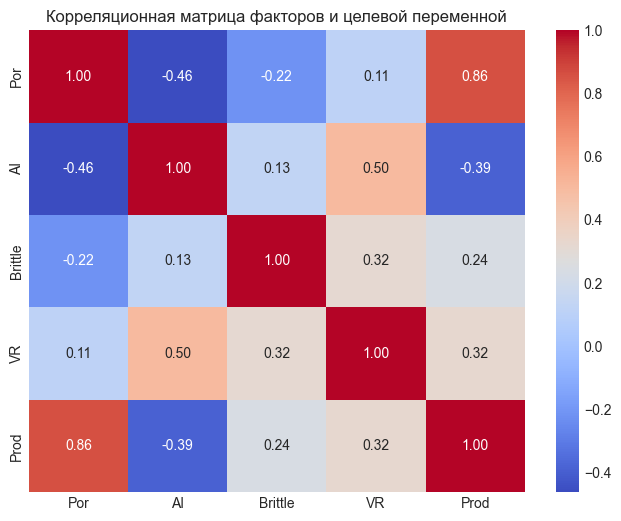

Коэффициенты линейной регрессии на обновленных данных: 
 intecept   -1835.0
Por          293.0
AI          -200.0
Brittle       28.0
VR           517.0
dtype: float64

MAPE на обновленных данных = 4.06


In [11]:
# Удалим сильно скоррелированные и незначительные факторы
columns_to_del = ['Well', 'TOC', 'Perm']
data.drop(columns=columns_to_del, inplace=True)

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Корреляционная матрица факторов и целевой переменной')
plt.show();

# Подготовим данные для модели
X = data.drop(columns=['Prod'])
y = data['Prod'].values
index = ['intecept'] + list(X.columns)
n = X.shape[0]
X = np.column_stack((np.ones(n), X))

coeff = np.linalg.inv(X.T @ X) @ X.T @ y  # модель линейной регрессии по МНК на обновленных данных
print('Коэффициенты линейной регрессии на обновленных данных: \n', pd.Series(coeff.round(), index=index))

y_pred = X @ coeff  # прогноз на новых коэффициентах
print()
print('MAPE на обновленных данных =', round(mean_absolute_percentage_error(y_pred, y)*100, 2))

#### 1) Интерпретация коэффициентов:

1. **Por (Пористость)**: коэффициент увеличился до 293 по сравнению с предыдущим значением (230), что подтверждает еще более значительное влияние этого признака на добычу газа.
   - Положительное значение коэффициента указывает на прямую зависимость: увеличение пористости на 1% приводит к увеличению добычи газа на 293 млн кубических футов в сутки.

2. **AI (Акустический импеданс)**: коэффициент изменился до -200 (был -365), но все еще остается отрицательным, указывая на обратную зависимость.
   - Хотя влияние уменьшилось, высокие значения акустического импеданса продолжают отрицательно сказываться на добыче газа. Увеличение акустического импеданса на 1 единицу приводит к снижению добычи газа на 200 млн кубических футов в сутки, при прочих равных.

3. **VR (Коэффициент отражения витринита)**: коэффициент уменьшился до 517 (был 785), но все еще значим для модели.
   - Это подтверждает положительное влияние витринита на добычу газа, но его влияние стало менее выраженным после удаления сильно коррелированных факторов. Увеличение коэффициента отражения витринита на 1 единицу связано с увеличением добычи на 517 млн кубических футов в сутки.

#### 2) Интерпретация метрики MAPE:
- **MAPE** выросло с 3.63% до 4.06%, что указывает на небольшое ухудшение качества прогноза в среднем на 0.43% и что может объясняться уменьшением числа факторов, учитываемых в прогнозе.

#### 3) Удалось ли устранить противоречие?
- **TOC** был исключен из модели, так как он имел высокую корреляцию с **Por** (0.71) и вызывал противоречие в предыдущей модели. Таким образом, **противоречие было устранено**.
- Теперь признаки в модели не имеют противоположных знаков по отношению к коэффициентам корреляции.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [58]:
# Подготовим данные для модели
X = data.drop(columns=['Prod'])
y = data['Prod'].values

# Обучим модель на обновленных данных
model_lr = LinearRegression()
model_lr.fit(X, y)

# Получим коэффициенты модели, включая свободный член
intercept = model_lr.intercept_
coefficients = model_lr.coef_

# Соберем коэффициенты в единый массив и округлим до целого
all_coefficients = [intercept] + list(coefficients)
all_coefficients = np.round(all_coefficients).astype(int)
print('Коэффициенты линейной регрессии в модели sklearn LinearRegression() = ', all_coefficients)

# Прогноз для всех скважин и вывод метрики MAPE
y_pred = model_lr.predict(X)
print('MAPE в модели sklearn LinearRegression() = ', round(mean_absolute_percentage_error(y_pred, y)*100, 2))

# Оценка модели линейной регрессии с помощью кросс-валидации (для заполнения сводной таблицы в последнем задании)
cv_results = cross_validate(model_lr, X, y, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True)
mape_train = round(-(cv_results['train_score'].mean() * 100), 2)
mape_val = round(-(cv_results['test_score'].mean() * 100),2)

print('MAPE на тренировочных фолдах: {}'.format(mape_train))
print('MAPE на валидационных фолдах: {}'.format(mape_val))

Коэффициенты линейной регрессии в модели sklearn LinearRegression() =  [-1835   293  -200    28   517]
MAPE в модели sklearn LinearRegression() =  4.06
MAPE на тренировочных фолдах: 4.02
MAPE на валидационных фолдах: 4.23


#### Заключение:
* Использование библиотеки scikit-learn упростило процесс расчета, но результаты полностью совпадают с тем, что было получено вручную. Это касается как коэффициентов, так и значения метрики MAPE.
* Это подтверждает корректность предыдущих вычислений и устойчивость модели к различным методам расчета.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [13]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [22]:
# Стандартизация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерация полиномиальных признаков третьего порядка
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

print('Количество факторов после генерации полиномиальных признаков = ', X_poly.shape[1])

lr = LinearRegression()

# Оценка модели линейной регрессии с помощью кросс-валидации
cv_results = cross_validate(lr, X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True)
mape_train = round(-(cv_results['train_score'].mean() * 100), 2)
mape_val = round(-(cv_results['test_score'].mean() * 100),2)

print('MAPE на тренировочных фолдах: {}'.format(mape_train))
print('MAPE на валидационных фолдах: {}'.format(mape_val))

Количество факторов после генерации полиномиальных признаков =  34
MAPE на тренировочных фолдах: 1.77
MAPE на валидационных фолдах: 2.68


1. **Количество факторов после генерации полиномиальных признаков**: 34.
   - После генерации полиномиальных признаков третьего порядка на основе 4 исходных признаков (**Por**, **AI**, **Brittle**, **VR**) количество факторов значительно увеличилось до 34.
   - Это связано с тем, что полиномиальные признаки включают все возможные комбинации этих факторов до третьей степени, включая квадратичные и кубические взаимодействия.

2. **MAPE на тренировочных фолдах: 1.77%**
   - Это значение указывает на среднюю абсолютную процентную ошибку на тренировочных данных. Низкое значение MAPE (1.77%) говорит о том, что модель очень точно предсказывает данные, на которых она обучалась.

3. **MAPE на валидационных фолдах: 2.68%**
   - Значение MAPE на валидации также остается достаточно низким, что говорит о хорошем качестве предсказания на данных, которые модель не видела во время обучения.
   - Хотя MAPE на валидации немного выше, чем на тренировочных данных, разница (менее 1%) свидетельствует о **низкой вероятности переобучения** модели и хорошей обобщающей способности.

#### Общие выводы:
- Низкие значения MAPE как на тренировочных (1.77%), так и на валидационных (2.68%) данных указывают на высокую предсказательную точность модели. Это свидетельствует о том, что использование полиномиальных признаков повысило качество модели.
- Разница между MAPE на тренировочных и валидационных данных небольшая, что говорит о сбалансированной модели, которая может эффективно предсказывать как известные, так и новые данные.
- Увеличение числа признаков до 34 повысило сложность модели, но это дало положительный эффект на точность предсказаний.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [59]:
# Стандартизация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерация полиномиальных признаков третьего порядка
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Создание модели Lasso
lasso = Lasso()

# Определение параметров для подбора
param_grid = {
    'alpha': np.logspace(-4, 1, 50)
}

# Выполнение GridSearchCV
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_poly, y)
best_params = grid_search.best_params_
print('Наилучший коэффициент регуляризации alpha = ', round(best_params['alpha']))

# Оценка модели линейной регрессии с регуляризацией Lasso с помощью кросс-валидации
cv_results = cross_validate(Lasso(alpha=best_params['alpha']), X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True)
mape_train = round(-(cv_results['train_score'].mean() * 100), 2)
mape_val = round(-(cv_results['test_score'].mean() * 100), 2)

print('MAPE на тренировочных фолдах Lasso: {}'.format(mape_train))
print('MAPE на валидационных фолдах Lasso: {}'.format(mape_val))

Наилучший коэффициент регуляризации alpha =  5
MAPE на тренировочных фолдах Lasso: 1.83
MAPE на валидационных фолдах Lasso: 2.28


/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.584e+05, tolerance: 1.474e+04
  model = cd_fast.enet_coordinate_descent(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.584e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

1. **Изменения**:
   - Добавлена регуляризация с помощью **Lasso-регрессии**, что позволило учитывать L1-наказание для уменьшения сложности модели и избежания переобучения.
   - Подобран оптимальный коэффициент регуляризации **alpha = 5**, что помогло модели выбрать только значимые факторы.

2. **Результаты**:
   - **MAPE на тренировочных фолдах**: 1.83
   - **MAPE на валидационных фолдах**: 2.28

   Теперь, значения MAPE на тренировочных и валидационных фолдах стали более сбалансированными, что указывает на улучшение обобщающей способности модели. Разница между тренировочными и валидационными показателями уменьшилась, что говорит о снижении риска переобучения.

3. **Выводы:**
- Использование Lasso-регуляризации помогло снизить переобучение и сделать модель более устойчивой к новым данным. Значения MAPE на валидационных данных уменьшились с 2.68 до 2.28, что является положительным улучшением.
- Увеличение MAPE на тренировочных данных с 1.77 до 1.83 указывает на то, что модель стала чуть менее "идеальной" на тренировочных данных, но это нормально, так как модель теперь лучше справляется с обобщением.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [60]:
# Стандартизация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерация полиномиальных признаков третьего порядка
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Создание модели Ridge
ridge = Ridge()

# Определение параметров для подбора
param_grid = {
    'alpha': np.logspace(-4, 1, 50)
}

# Выполнение GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_poly, y)
best_params = grid_search.best_params_
print('Наилучший коэффициент регуляризации alpha = ', round(best_params['alpha'],2))

# Оценка модели линейной регрессии с регуляризацией Ridge с помощью кросс-валидации
cv_results = cross_validate(Ridge(alpha=best_params['alpha']), X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True)
mape_train = round(-(cv_results['train_score'].mean() * 100), 2)
mape_val = round(-(cv_results['test_score'].mean() * 100), 2)

print('MAPE на тренировочных фолдах Ridge: {}'.format(mape_train))
print('MAPE на валидационных фолдах Ridge: {}'.format(mape_val))

Наилучший коэффициент регуляризации alpha =  0.15
MAPE на тренировочных фолдах Ridge: 1.77
MAPE на валидационных фолдах Ridge: 2.67


1. **Изменения**:
   - Добавлена регуляризация с помощью **Ridge-регрессии**, что позволило учитывать L2-наказание для уменьшения сложности модели и избежания переобучения.
   - Подобран оптимальный коэффициент регуляризации **alpha = 0.15**, что помогло модели выбрать только значимые факторы.

2. **Результаты**:
   - **MAPE на тренировочных фолдах**: 1.77
   - **MAPE на валидационных фолдах**: 2.67

3. **Выводы:**
- Использование Ridge-регуляризации помогло снизить метрику MAPE до 1.77 на тренировочных фолдах в сравнении с Lasso-регуляризацией. Однако метрика MAPE увеличилась до 2.67 на валидационных фолдах. В итоге получены метрики на тренировочных и валидационных фолдах, аналогичные метрикам до применения регуляризации.
- Lasso-регрессия демонстрирует лучшую обобщающую способность на валидационных данных (значение MAPE ниже, чем у Ridge), что указывает на более эффективное устранение нерелевантных признаков.
- Ridge-регрессия лучше справляется на тренировочных данных, но имеет немного худшие результаты на валидационных, что может говорить о том, что модель чуть менее эффективна при работе с новыми данными.

4. **Возможные причины:**
* **Lasso-регрессия** использует L1-регуляризацию, которая склонна "занулять" коэффициенты нерелевантных признаков, делая модель проще и исключая ненужные факторы. Это объясняет более высокий коэффициент alpha и более низкий MAPE на валидационных данных, так как модель становится более устойчивой к шуму.
* **Ridge-регрессия** использует L2-регуляризацию, которая "штрафует" большие коэффициенты, уменьшая их, но не исключает признаки полностью. Это объясняет меньший коэффициент alpha, так как Ridge работает с большинством факторов, делая модель более гибкой.

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [61]:
# Стандартизация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерация полиномиальных признаков третьего порядка
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Создание модели ElasticNet
elastic_net = ElasticNet()

# Определение параметров для подбора
param_grid = {
    'alpha': np.logspace(-4, 1, 50),
    'l1_ratio': np.logspace(-4, 1, 50)
}

# Выполнение GridSearchCV
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_poly, y)
best_params = grid_search.best_params_
print('Наилучший коэффициент регуляризации alpha = ', round(best_params['alpha'],2))
print('Наилучший коэффициент регуляризации l1_ratio = ', round(best_params['l1_ratio'],2))

# Оценка модели линейной регрессии с регуляризацией ElasticNet с помощью кросс-валидации
cv_results = cross_validate(ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio']), X_poly, y, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True)
mape_train = round(-(cv_results['train_score'].mean() * 100), 2)
mape_val = round(-(cv_results['test_score'].mean() * 100), 2)

print('MAPE на тренировочных фолдах ElasticNet: {}'.format(mape_train))
print('MAPE на валидационных фолдах ElasticNet: {}'.format(mape_val))

/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.767e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.519e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Наилучший коэффициент регуляризации alpha =  0.04
Наилучший коэффициент регуляризации l1_ratio =  0.95
MAPE на тренировочных фолдах ElasticNet: 1.77
MAPE на валидационных фолдах ElasticNet: 2.66


/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2500 fits failed out of a total of 12500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/b

#### **Результаты ElasticNet-регрессии:**
1. **Наилучшие коэффициенты регуляризации**:
   - **`alpha` = 0.04** — это значение регуляризации, которое контролирует общий уровень штрафа. Значение относительно невелико, что означает умеренную регуляризацию.
   - **`l1_ratio` = 0.95** — это значение коэффициента, которое определяет баланс между L1 и L2 регуляризациями. Значение 0.95 указывает на то, что модель в основном использует L1-регуляризацию (Lasso), но также включает небольшую долю L2-регуляризации.

2. **Метрика MAPE**:
   - **MAPE на тренировочных фолдах**: 1.77 %
   - **MAPE на валидационных фолдах**: 2.66 %

   Эти результаты почти совпадают с результатами Ridge-регрессии, что указывает на стабильность модели и ее хорошую способность к обобщению.

#### **Интерпретация:**
1. **Регуляризация**:
   - Высокое значение **`l1_ratio` = 0.95** означает, что ElasticNet в данном случае практически ведет себя как Lasso-регрессия, отдавая предпочтение L1-регуляризации. Это говорит о том, что для данных важно "занулять" незначимые признаки, что делает модель проще и устойчивее к шуму.
   - Низкое значение **`alpha` = 0.04** означает, что модель применяет слабую регуляризацию, сохраняя большую часть информации в данных.

2. **Точность модели**:
   - Значения MAPE на тренировочных и валидационных данных схожи с результатами Ridge-регрессии:
     - **MAPE на тренировочных данных**: 1.77 — модель хорошо обучена на тренировочных данных.
     - **MAPE на валидационных данных**: 2.66 — модель стабильно показывает схожие результаты на новых данных, что говорит об отсутствии явного переобучения.
   
#### **Сравнение с другими моделями:**
- **Lasso-регрессия** показала более низкий MAPE на валидационных данных (2.28), что делает её немного предпочтительнее в плане точности на новых данных, но разница несущественна.
- **Ridge-регрессия** имела значение MAPE 2.67 на валидационных данных, что практически идентично результатам ElasticNet, но `alpha` в Ridge был очень мал (0.15), что может указывать на меньшую потребность в регуляризации.

#### **Выводы:**
1. **ElasticNet как баланс L1 и L2**: Значение `l1_ratio = 0.95` показывает, что L1-регуляризация остается ключевым фактором для данной задачи, но добавление L2-регуляризации может немного улучшить устойчивость модели.
2. **Похожие результаты**: Значения MAPE для ElasticNet, Lasso и Ridge очень близки, что говорит о том, что данные хорошо аппроксимируются линейной моделью, и даже небольшие изменения в параметрах регуляризации не оказывают значимого влияния.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [64]:
# Создание сводной таблицы с результатами моделей
data_ru = {
    "Модель": [
        "Линейная регрессия", 
        "Полиномиальная регрессия (степень=3)", 
        "Lasso-регрессия", 
        "Ridge-регрессия", 
        "ElasticNet-регрессия"
    ],
    "Гиперпараметры": [
        "", 
        "", 
        "alpha=5", 
        "alpha=0.15", 
        "alpha=0.04, l1_ratio=0.95"
    ],
    "Использовались полиномиальные признаки": [
        False, 
        True, 
        True, 
        True, 
        True
    ],
    "MAPE на тренировочных фолдах (в %)": [
        4.02, 
        1.77, 
        1.83, 
        1.77, 
        1.77
    ],
    "MAPE на валидационных фолдах (в %)": [
        4.23, 
        2.68, 
        2.28, 
        2.67, 
        2.66
    ]
}

# Создание DataFrame
results_df_ru = pd.DataFrame(data_ru)
display(results_df_ru)


,Модель,Гиперпараметры,Использовались полиномиальные признаки,MAPE на тренировочных фолдах (в %),MAPE на валидационных фолдах (в %)
0,Линейная регрессия,,False,4.02,4.23
1,Полиномиальная регрессия (степень=3),,True,1.77,2.68
2,Lasso-регрессия,alpha=5,True,1.83,2.28
3,Ridge-регрессия,alpha=0.15,True,1.77,2.67
4,ElasticNet-регрессия,"alpha=0.04, l1_ratio=0.95",True,1.77,2.66


### Подведем общий вывод по моделям: 
1. **Лучшая модель по качеству на валидационных фолдах**:
   - **Lasso Regression** показала наименьшее значение MAPE на валидационных фолдах (2.28). Это указывает на то, что Lasso наилучшим образом справилась с обобщением данных, показывая высокую устойчивость к новым данным.

2. **Оценка переобученности**:
   - **Polynomial Regression (степень 3)** показала самую большую разницу между MAPE на тренировочных и валидационных данных (0.91) среди остальных моделей, что указывает на ее наиболее сильное переобучение среди прочих.
   - **Lasso Regression** и **ElasticNet Regression** показали схожую разницу между MAPE на тренировочных и валидационных данных (в среднем 0.90)
   - **Linear Regression** (без полиномиальных признаков) показала самую маленькую разницу в MAPE (0.21), что говорит об отсутствии явного переобучения. Однако абсолютные значения MAPE высоки, что указывает на недостаточную сложность модели для адекватного описания данных.

### **Итоговый вывод:**
- В случаях, когда важны интерпретируемость, простота, качество на валидационной выборке и степень переобученности, то **Lasso Regression** является **наилучшим выбором**, так как она помогает исключить нерелевантные признаки и демонстрирует наименьшее значение MAPE на валидационных фолдах - 2.28, а разница MAPE составляет 0.45.
